### 5.2 Veri Seti hazırlanması

In [1]:
# import libraries
import torch # pytorch
import torch.nn as nn # sinir agi katmanlari icin
import torch.optim as optim # optimizasyon algoritmasi icin
import torchvision # goruntu isleme icin
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load dataset
def get_data_loaders(batch_size = 64): # batch size her iterasyonda islenecek veri sayisi
    
    transform = transforms.Compose([
        transforms.ToTensor(), # goruntuyu tensor e cevir
        transforms.Normalize(((0.5, 0.5, 0.5)), (0.5, 0.5, 0.5)) # rgb kanallarini normalize et
        ])
    
    # CIFAR10 veri setini indir ve egitim test veri setini olustur
    train_set = torchvision.datasets.CIFAR10(root = "./data", train = True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root = "./data", train = False, download=True, transform=transform)
    
    # dataLoader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

#### 5.3 Veri Görsellestirme

In [ ]:
# visualize dataset

def imshow(img):
    # verileri normalize etmeden once geri donustur
    img = img / 2 + 0.5 # normalize isleminin  tersi
    np_img = img.detach().numpy() # tensor dan numpy array e dondur
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # 3 kanal icin renkleri dogru sekilde gosterme
    plt.axis("off")
    
def get_sample_images(train_loader): # veri kumesinden ornek gorselleri almak icin fonksiyon
    
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    return images, labels

def visualize(n):
    train_loader, test_loader = get_data_loaders()
    
    # n tane veri gorsellestirme
    images, labels = get_sample_images(train_loader)
    plt.figure(figsize=(n * 2, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i]) # gorsellestir
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.show()
    
# visualize(10) 

#### 5.4 Modelin Olusturulması 

In [ ]:
# build CNN Model

class CNN(nn.Module):
    
    def __init__(self):
        
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # in_channels = rgb 3, out_channels filtre sayisi, kernel_size 3x3
        self.relu = nn.ReLU() # aktivayon fonksiyonu
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # 2x2 boyutunda poolşng katmani
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding = 1) # 64 filtreli ikinci convolution layer
        self.dropout = nn.Dropout(0.2) # dropout %20 oraninda calisir
        self.fc1 = nn.Linear(64*8*8, 128) # fully connected layer giris = 4096, output = 128
        self.fc2 = nn.Linear(128, 10) # output layer
        
        # image 3x32x32 -> conv (32) -> relu (32) -> pool (16)
        # conv (16) -> relu (16) -> pool (8) -> image = 8x8
        
    def forward(self, x):
        """
            image 3x32x32 -> conv (32) -> relu (32) -> pool (16)
            conv (16) -> relu (16) -> pool (8) -> image = 8x8
            flatten
            fc1 -> relu -> dropout
            fc2 -> output
        """
        x = self.pool(self.relu(self.conv1(x))) # ilk convolution blok
        x = self.pool(self.relu(self.conv2(x))) # ikinci convolution blok
        x = x.view(-1, 64*8*8) # flatten
        x = self.dropout(self.relu(self.fc1(x))) # fully connected layer
        x = self.fc2(x) # output
        return x

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNN().to(device)

# define loss function and optimizer
define_loss_and_optimizer = lambda model: (
    nn.CrossEntropyLoss(), # multi class classification problem
    optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9) # stochastic gradient descent
)

#### 5.5 Modelin Egitilmesi

In [4]:
# training

def train_model(model, train_loader, criterion, optimizer, epochs = 5):
    
    model.train() # modeli egitim moduna alalim
    train_losses = [] # loss degerlerini saklamak icin bir liste olustur
    
    for epoch in range(epochs): # for dongusu olustur belirtilen epoch sayisi kadar
        total_loss = 0 # toplam loss degerini saklamak icin total_loss 
        for images, labels in train_loader: # for dongusu tum egitim veri setini taramak icin
            images, labels = images.to(device), labels.to(device) 
            
            optimizer.zero_grad() # gradyanlari sifirlamak 
            outputs = model(images) # forward pro. (prediction) output = etiket, label, class
            loss = criterion(outputs, labels) # loss degeri hesapla
            loss.backward() # geri yayilim (gradyan hesaplama)
            optimizer.step() # ogrenme = parametre yani agirlik guncelleme
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader) # ortalam kayip hesaplama
        train_losses.append(avg_loss)
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.5f}")
        
    # kayip (loss) grafigi
    plt.figure()
    plt.plot(range(1, epochs + 1), train_losses, marker = "o", linestyle = "-", label = "Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()
            
# train_loader, test_loader = get_data_loaders()
# model = CNN().to(device)
# criterion, optimizer = define_loss_and_optimizer(model)
# train_model(model, train_loader, criterion, optimizer, epochs = 10)

#### 5.6 Modelin test edilmesi ve degerlendirilmesi

In [ ]:
# %% test

def test_model(model, test_loader, dataset_type):
    
    model.eval() # degerlendirme modu
    correct = 0 # dogru tahmin sayaci
    total = 0 # toplam veri sayaci
    
    with torch.no_grad(): # gradyan hesaplamasini kapat
        for images, labels in test_loader: # test veri setini kullanarak degerlerndirme
            images, labels = images.to(device), labels.to(device) # verileri cihaza tasi
             
            outputs = model(images) # prediction
            _, predicted = torch.max(outputs, 1) # en yuksek olasilikli sinifi sec
            total += labels.size(0) # toplam veri sayisi
            correct += (predicted == labels).sum().item() # dogru tahminleri say
            
    print(f"{dataset_type} accuracy: {100 * correct / total} %") # dogruluk oranini ekrana yazdir

# test_model(model, test_loader, dataset_type = "test") # test accuracy: 63.21 %
# test_model(model, train_loader, dataset_type= "training") # training accuracy: 65.716 %

# https://paperswithcode.com/sota/image-classification-on-cifar-10

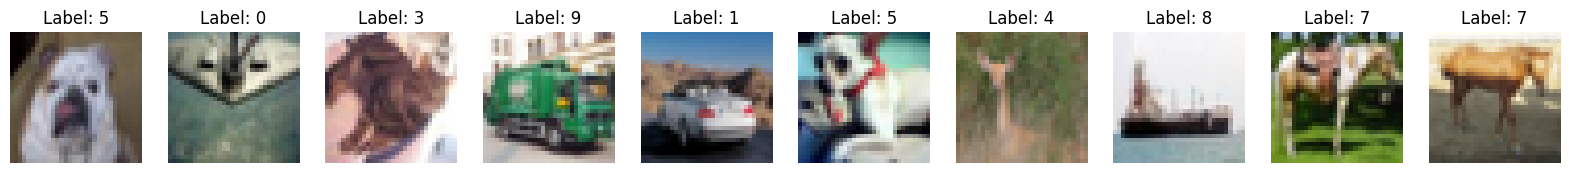

Epoch: 1/10, Loss: 2.07665
Epoch: 2/10, Loss: 1.72156
Epoch: 3/10, Loss: 1.51728
Epoch: 4/10, Loss: 1.39867
Epoch: 5/10, Loss: 1.32070
Epoch: 6/10, Loss: 1.25422
Epoch: 7/10, Loss: 1.20139
Epoch: 8/10, Loss: 1.15416
Epoch: 9/10, Loss: 1.11003
Epoch: 10/10, Loss: 1.06755


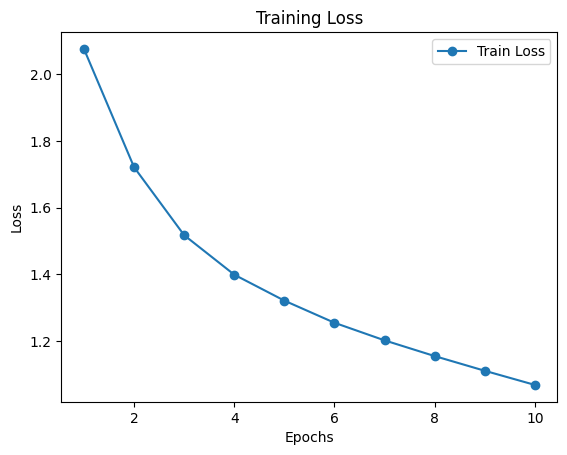

test accuracy: 62.8 %
training accuracy: 65.51 %


In [ ]:
# %% main program

if __name__ == "__main__":
    
    # veri seti yukleme
    train_loader, test_loader = get_data_loaders()
    
    # gorsellestirme
    visualize(10)
    
    # training
    model = CNN().to(device)
    criterion, optimizer = define_loss_and_optimizer(model)
    train_model(model, train_loader, criterion, optimizer, epochs = 10)
    
    # test
    test_model(model, test_loader, dataset_type = "test")
    test_model(model, train_loader, dataset_type= "training")